# Analisis geoespacial con Geopandas

In [1]:

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Leemos CSV de hospitales (Latin-1)
hospitals = pd.read_csv("IPRESS.csv", encoding="latin1")

# Leemos shapefile de distritos y convertir CRS ---
districts = gpd.read_file(r"shape_file\DISTRITOS.shp").to_crs(epsg=4326)

# Leer shapefile de centros poblados y convertir CRS 
pop_centers = gpd.read_file(r"CCPP_0\CCPP_IGN100K.shp").to_crs(epsg=4326)


In [11]:
hospitals

,Institución,Código Único,Nombre del establecimiento,Clasificación,Tipo,Departamento,Provincia,Distrito,UBIGEO,Dirección,...,Inicio de Actividad,Director Médico y/o Responsable de la Atención de Salud,Estado,Situación,Condición,Inspección,NORTE,ESTE,COTA,CAMAS
0,PRIVADO,16618,SONRIE MAS,CONSULTORIOS MEDICOS Y DE OTROS PROFESIONALES ...,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,LIMA,LIMA,SANTIAGO DE SURCO,150140,"AV. CAMINOS DEL INCA 2028 OF.201, URBANIZACION...",...,11/03/2013,GILBERTO MARTIN AQUIJE GAVILAN,ACTIVADO,,EN FUNCIONAMIENTO,,NaN,NaN,NaN,NaN
1,GOBIERNO REGIONAL,7050,AMBATO,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,CAJAMARCA,CUTERVO,SANTA CRUZ,60611,COMUNIDAD DE AMBATO,...,29/06/2006,IDELSO MENOR CHAVEZ,ACTIVADO,,EN FUNCIONAMIENTO,,-78.858380,-6.133523,1724.0,NaN
2,GOBIERNO REGIONAL,99,SANTA ISABEL DE YUMBATURO,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,LORETO,LORETO,PARINARI,160302,ACTUALIZAR,...,01/01/1900,JULIO TONY CAITIMARI MACHOA,ACTIVADO,,EN FUNCIONAMIENTO,,-74.258139,-4.581509,124.0,NaN
3,PRIVADO,19555,DENTOCAPLINA,CONSULTORIOS MEDICOS Y DE OTROS PROFESIONALES ...,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,TACNA,TACNA,TACNA,230101,AV.LEGUIA 1892,...,30/12/2014,BYANCA LISSETTE ARANDA LANCHIPA,ACTIVADO,,EN FUNCIONAMIENTO,,NaN,NaN,NaN,NaN
4,OTRO,18792,MEDICO DE FAMILIA MANTARA,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,JUNIN,TARMA,TARMA,120701,JR. ROSA ZAPATEL S/N - BARRIO MANTARA - TARMA,...,06/07/2014,LILIAN DENISE ADAUTO DE LA CRUZ,ACTIVADO,,EN FUNCIONAMIENTO,,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20814,GOBIERNO REGIONAL,2283,P.S NUEVO HUALAPAMPA,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,PIURA,HUANCABAMBA,HUARMACA,200304,CENTRO POBLADO NUEVO HUALAPAMPA S/N,...,01/01/1900,NaN,ACTIVADO,,EN FUNCIONAMIENTO,,-79.437187,-5.789407,1364.0,NaN
20815,GOBIERNO REGIONAL,2278,P.S SAN MARTIN DE CONGOÑA,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,PIURA,HUANCABAMBA,HUARMACA,200304,CENTRO POBLADO SAN MARTIN DE CONGOÑA S/N,...,01/01/1900,NaN,ACTIVADO,,EN FUNCIONAMIENTO,,-79.627953,-5.644592,1320.0,NaN
20816,GOBIERNO REGIONAL,2274,P.S TUNAS,PUESTOS DE SALUD O POSTAS DE SALUD,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,PIURA,HUANCABAMBA,HUARMACA,200304,CENTRO POBLADO TUNAS,...,01/01/1900,NaN,ACTIVADO,,EN FUNCIONAMIENTO,,-79.546778,-5.498508,1549.0,NaN
20817,GOBIERNO REGIONAL,2272,C.S LIMON DE PORCUYA,CENTROS DE SALUD O CENTROS MEDICOS,ESTABLECIMIENTO DE SALUD SIN INTERNAMIENTO,PIURA,HUANCABAMBA,HUARMACA,200304,CENTRO POBLADO LIMON DE PORCUYA,...,01/01/1900,NaN,ACTIVADO,,EN FUNCIONAMIENTO,,-79.537903,-5.889830,1612.0,NaN


In [3]:
#Filtramos hospitales operativos
hospitals_operational = hospitals[hospitals['Condición'] == "EN FUNCIONAMIENTO"].copy()

#filtramos para tener solo hospitales públicos

hospitals_operational = hospitals_operational[((hospitals_operational['Clasificación'] == "HOSPITALES O CLINICAS DE ATENCION GENERAL") |
(hospitals_operational['Clasificación'] == "HOSPITALES O CLINICAS DE ATENCION ESPECIALIZADA")|
(hospitals_operational['Clasificación'] == "INSTITUTOS DE SALUD ESPECIALIZADOS")) &
(hospitals_operational['Institución'] != "PRIVADO")
].copy()

# código para mantener solo coordenadas válidas 
hospitals_operational.loc[:, 'NORTE'] = pd.to_numeric(
    hospitals_operational['NORTE'], errors='coerce')
hospitals_operational.loc[:, 'ESTE'] = pd.to_numeric(
    hospitals_operational['ESTE'], errors='coerce')

# Eliminamos filas sin coordenadas válidas
hospitals_operational = hospitals_operational.dropna(subset=['NORTE', 'ESTE'])


In [4]:
# Convertimos hospitales a GeoDataFrame 
hospitals_gdf = gpd.GeoDataFrame(
    hospitals_operational,
    geometry=gpd.points_from_xy(
        hospitals_operational['ESTE'],
        hospitals_operational['NORTE']
    ),
    crs="EPSG:4326"
)

# Contamos hospitales por distrito 
hospitals_count = hospitals_operational.groupby('Distrito').size().reset_index(name='n_hospitals')



In [5]:


districts = districts.merge(
    hospitals_count,
    left_on='DISTRITO',
    right_on='Distrito',
    how='left'
)

# Rellenamos distritos sin hospitales con 0
districts['n_hospitals'] = districts['n_hospitals'].fillna(0)

# resultados
print(districts[['DISTRITO', 'n_hospitals']].head())
print(hospitals_gdf.head())

                 DISTRITO  n_hospitals
0         CODO DEL POZUZO          0.0
1             TOURNAVISTA          0.0
2  ALEXANDER VON HUMBOLDT          0.0
3                 IRAZOLA          0.0
4                 NESHUYA          0.0
           Institución  Código Único  \
17   GOBIERNO REGIONAL          2941   
35   GOBIERNO REGIONAL          1516   
52   GOBIERNO REGIONAL          5263   
275              MINSA          5987   
339            ESSALUD          8685   

                            Nombre del establecimiento  \
17                              CARLOS CORNEJO ROSELLO   
35                                             CARHUAZ   
52   HOSPITAL PROVINCIAL ASCOPE "ROSA SANCHEZ DE SA...   
275                         HOSPITAL MARIA AUXILIADORA   
339                                HOSPITAL I ALBRECHT   

                                       Clasificación  \
17         HOSPITALES O CLINICAS DE ATENCION GENERAL   
35         HOSPITALES O CLINICAS DE ATENCION GENERAL   
52      

# TASK 1: MAPAS ESTÁTICOS

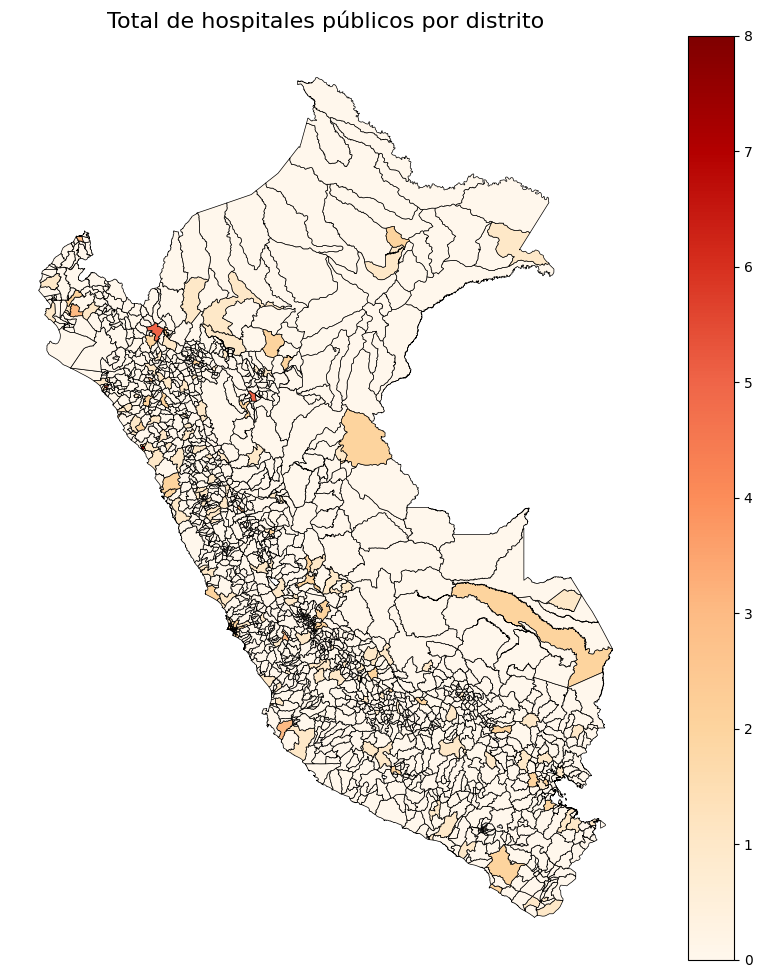

In [8]:
import matplotlib.pyplot as plt

# Mapa 1: Total de hospitales públicos por distrito
# -------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
districts.plot(
    column='n_hospitals',
    cmap='OrRd',
    linewidth=0.5,
    edgecolor='black',
    legend=True,
    ax=ax
)
ax.set_title("Total de hospitales públicos por distrito", fontsize=16)
ax.axis('off')
plt.show()


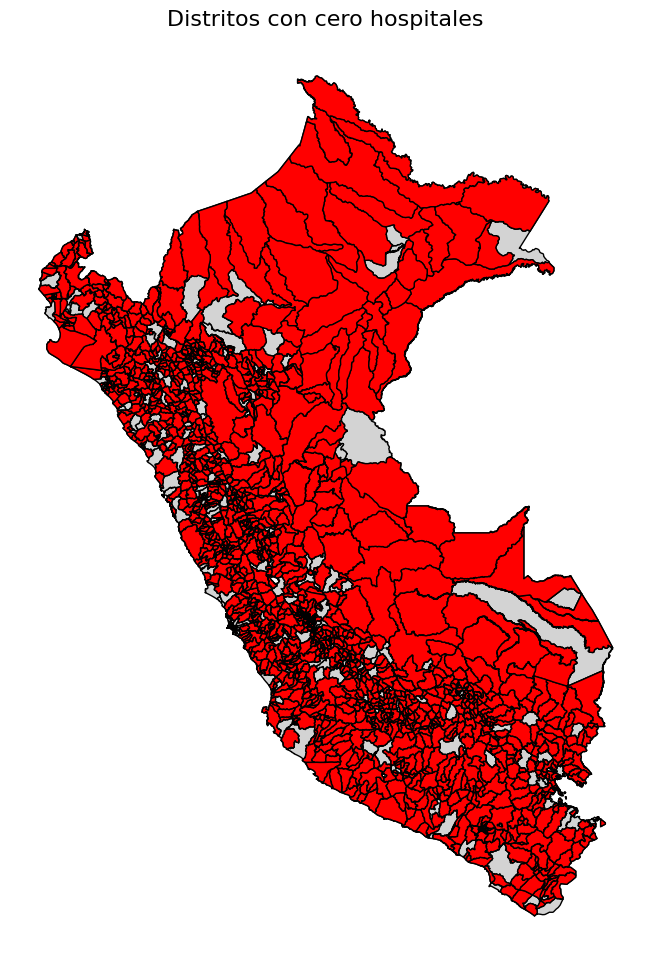

In [9]:

# Mapa 2: Distritos con cero hospitales

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
districts['zero_hospitals'] = districts['n_hospitals'] == 0
districts.plot(
    color='lightgrey', 
    edgecolor='black', 
    ax=ax
)
districts[districts['zero_hospitals']].plot(
    color='red',
    edgecolor='black',
    ax=ax
)
ax.set_title("Distritos con cero hospitales", fontsize=16)
ax.axis('off')
plt.show()

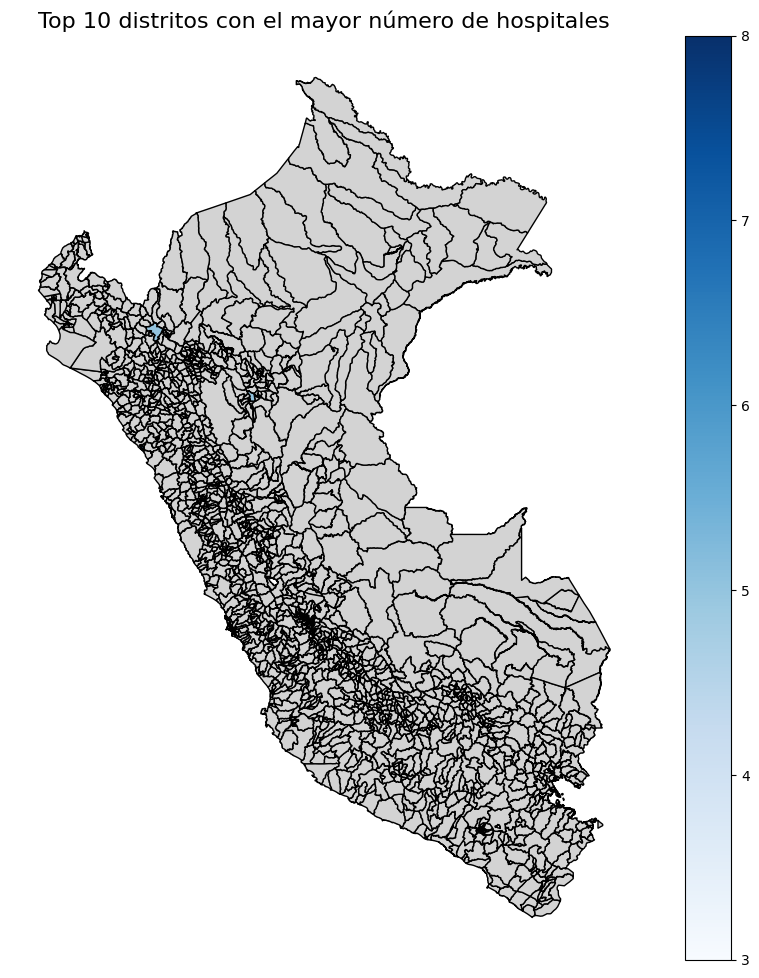

In [10]:
 # Mapa 3: Top 10 distritos con el mayor número de hospitales
# -------------------------
top10 = districts.nlargest(10, 'n_hospitals')

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
districts.plot(
    color='lightgrey',
    edgecolor='black',
    ax=ax
)
top10.plot(
    column='n_hospitals',
    cmap='Blues',
    edgecolor='black',
    legend=True,
    ax=ax
)
ax.set_title("Top 10 distritos con el mayor número de hospitales", fontsize=16)
ax.axis('off')
plt.show()

In [50]:
print(top10)

     IDDPTO   DEPARTAMEN IDPROV   PROVINCIA  IDDIST     DISTRITO      CAPITAL  \
1289     15         LIMA   1501        LIMA  150101         LIMA         LIMA   
1396     13  LA LIBERTAD   1301    TRUJILLO  130101     TRUJILLO     TRUJILLO   
522      06    CAJAMARCA   0608        JAEN  060802   BELLAVISTA   BELLAVISTA   
1223     07       CALLAO   0701      CALLAO  070102   BELLAVISTA   BELLAVISTA   
1415     22   SAN MARTIN   2202  BELLAVISTA  220201   BELLAVISTA   BELLAVISTA   
1544     14   LAMBAYEQUE   1401    CHICLAYO  140101     CHICLAYO     CHICLAYO   
1709     20        PIURA   2006     SULLANA  200602   BELLAVISTA   BELLAVISTA   
100      04     AREQUIPA   0401    AREQUIPA  040101     AREQUIPA     AREQUIPA   
1004     15         LIMA   1501        LIMA  150113  JESUS MARIA  JESUS MARIA   
111      04     AREQUIPA   0401    AREQUIPA  040110   MIRAFLORES   MIRAFLORES   

     CODCCPP  AREA FUENTE                                           geometry  \
1289    0001     1   INEI  P

In [54]:
districts

,IDDPTO,DEPARTAMEN,IDPROV,PROVINCIA,IDDIST,DISTRITO,CAPITAL,CODCCPP,AREA,FUENTE,geometry,Distrito_x,n_hospitals_x,zero_hospitals,Distrito_y,n_hospitals_y,Distrito,n_hospitals
0,10,HUANUCO,1009,PUERTO INCA,100902,CODO DEL POZUZO,CODO DEL POZUZO,0001,1,INEI,"POLYGON ((-75.31797 -9.29529, -75.3171 -9.2975...",CODO DEL POZUZO,3.0,False,NaN,NaN,NaN,0.0
1,10,HUANUCO,1009,PUERTO INCA,100904,TOURNAVISTA,TOURNAVISTA,0001,1,INEI,"POLYGON ((-74.64136 -8.82302, -74.64036 -8.828...",TOURNAVISTA,4.0,False,NaN,NaN,NaN,0.0
2,25,UCAYALI,2503,PADRE ABAD,250305,ALEXANDER VON HUMBOLDT,ALEXANDER VON HUMBOLDT,0001,1,INEI,"POLYGON ((-75.02253 -8.74193, -75.02267 -8.742...",ALEXANDER VON HUMBOLDT,2.0,False,NaN,NaN,NaN,0.0
3,25,UCAYALI,2503,PADRE ABAD,250302,IRAZOLA,SAN ALEJANDRO,0001,1,INEI,"POLYGON ((-75.13864 -8.56712, -75.13956 -8.569...",IRAZOLA,7.0,False,NaN,NaN,NaN,0.0
4,25,UCAYALI,2503,PADRE ABAD,250304,NESHUYA,MONTE ALEGRE,0001,1,INEI,"POLYGON ((-75.01589 -8.44637, -75.01585 -8.446...",NESHUYA,7.0,False,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1868,10,HUANUCO,1006,LEONCIO PRADO,100608,CASTILLO GRANDE,CASTILLO GRANDE,0001,1,INEI,"POLYGON ((-76.08083 -9.13017, -76.08026 -9.130...",CASTILLO GRANDE,1.0,False,NaN,NaN,NaN,0.0
1869,10,HUANUCO,1006,LEONCIO PRADO,100609,PUEBLO NUEVO,PUEBLO NUEVO,0001,1,INEI,"POLYGON ((-75.88828 -9.00906, -75.88756 -9.010...",PUEBLO NUEVO,14.0,False,NaN,NaN,NaN,0.0
1870,10,HUANUCO,1006,LEONCIO PRADO,100610,SANTO DOMINGO DE ANDA,PACAE,0001,1,INEI,"POLYGON ((-75.91141 -8.88593, -75.91182 -8.886...",SANTO DOMINGO DE ANDA,1.0,False,NaN,NaN,NaN,0.0
1871,21,PUNO,2111,SAN ROMAN,211105,SAN MIGUEL,SAN MIGUEL,0001,1,INEI,"POLYGON ((-70.13203 -15.33382, -70.12355 -15.3...",SAN MIGUEL,18.0,False,SAN MIGUEL,2.0,SAN MIGUEL,2.0


# Task 2: análisis a nivel departamento

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Agregamos hospitales por departamento

# Asegurarse que districts tenga columna DEPARTAMENTO y n_hospitals
dept_hospitals = districts.groupby('DEPARTAMEN')['n_hospitals'].sum().reset_index()

# Ordenar de mayor a menor
dept_hospitals = dept_hospitals.sort_values(by='n_hospitals', ascending=False)
dept_hospitals.reset_index(drop=True, inplace=True)


In [12]:
# Identificamos máximos y mínimos

max_dept = dept_hospitals.iloc[0]
min_dept = dept_hospitals.iloc[-1]

print(f"Department with highest hospitals: {max_dept['DEPARTAMEN']} ({max_dept['n_hospitals']})")
print(f"Department with lowest hospitals: {min_dept['DEPARTAMEN']} ({min_dept['n_hospitals']})")

# Tabla de resumen

print(dept_hospitals) 


Department with highest hospitals: LIMA (59.0)
Department with lowest hospitals: TACNA (2.0)
       DEPARTAMEN  n_hospitals
0            LIMA         59.0
1     LA LIBERTAD         34.0
2       CAJAMARCA         22.0
3          ANCASH         18.0
4           JUNIN         16.0
5      SAN MARTIN         16.0
6        AREQUIPA         15.0
7           PIURA         15.0
8            PUNO         15.0
9        AYACUCHO         14.0
10     LAMBAYEQUE         10.0
11          CUSCO          9.0
12            ICA          9.0
13        HUANUCO          8.0
14         LORETO          8.0
15         CALLAO          8.0
16       AMAZONAS          8.0
17       APURIMAC          7.0
18   HUANCAVELICA          6.0
19          PASCO          5.0
20       MOQUEGUA          4.0
21  MADRE DE DIOS          3.0
22         TUMBES          3.0
23        UCAYALI          3.0
24          TACNA          2.0


C:\Users\Joaquin\AppData\Local\Temp\ipykernel_25684\654079571.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


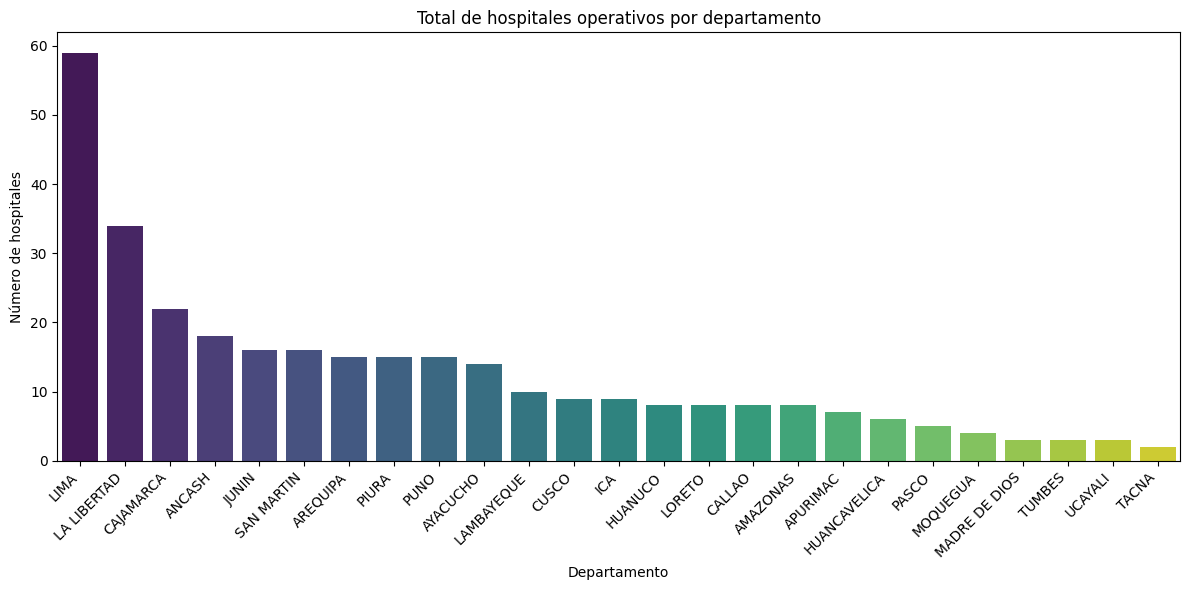

In [13]:
# Gráfico de barras:-
plt.figure(figsize=(12,6))
sns.barplot(
    x='DEPARTAMEN',
    y='n_hospitals',
    data=dept_hospitals,
    palette='viridis'
)
plt.xticks(rotation=45, ha='right')
plt.title("Total de hospitales operativos por departamento")
plt.ylabel("Número de hospitales")
plt.xlabel("Departamento")
plt.tight_layout()
plt.show()

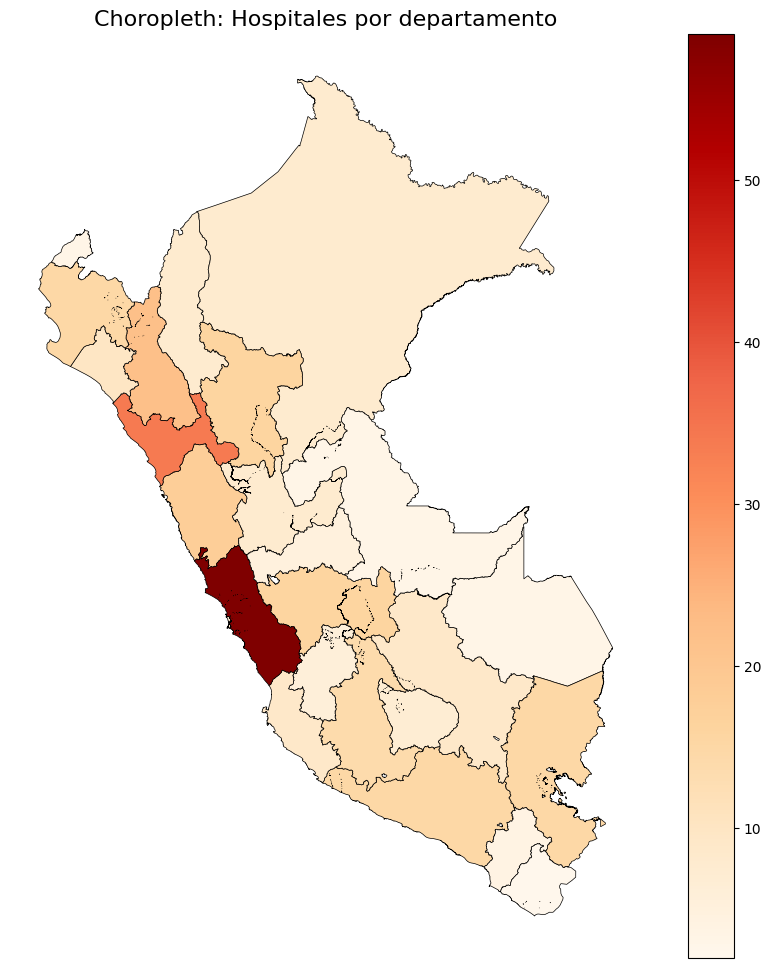

In [14]:
# Primero agregamos los hospitales al shapefile de distritos
# luego agrupamos al nivel departamento usando dissolve
dept_map = districts.dissolve(by='DEPARTAMEN', aggfunc='sum')

# Graficamos choropleth
fig, ax = plt.subplots(1,1, figsize=(12,12))
dept_map.plot(
    column='n_hospitals',
    cmap='OrRd',
    edgecolor='black',
    linewidth=0.5,
    legend=True,
    ax=ax
)
ax.set_title("Choropleth: Hospitales por departamento", fontsize=16)
ax.axis('off')
plt.show()

# TASK 3: ANÁLISIS DE PROXIMIDAD 

In [63]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import folium

# Filtramos centros poblados por región:

regions = ["LIMA", "LORETO"]  # nombres exactos según shapefile
pop_centers_region = pop_centers[pop_centers['DEP'].isin(regions)].copy()

In [65]:
# Limpiamos geometrías (porseacaso)

pop_centers_region = pop_centers_region[pop_centers_region.geometry.notnull()].copy()
hospitals_gdf = hospitals_gdf[hospitals_gdf.geometry.notnull()].copy()


# Reproyectamos a CRS métrico para buffer 10 km

crs_metric = "EPSG:32718"  # UTM zona para Lima/Loreto, ajusta si necesario
pop_centers_region = pop_centers_region.to_crs(crs_metric)
hospitals_gdf_metric = hospitals_gdf.to_crs(crs_metric)


In [67]:
# Creamos buffer de 10 km y contamos hospitales cercanos

pop_centers_region['buffer_10km'] = pop_centers_region.geometry.buffer(10000)  # 10 km en metros

def count_hospitals_in_buffer(buffer_geom):
    return hospitals_gdf_metric[hospitals_gdf_metric.geometry.within(buffer_geom)].shape[0]

pop_centers_region['hospitals_nearby'] = pop_centers_region['buffer_10km'].apply(count_hospitals_in_buffer)

# Identificamos valores extremos por región
for region in regions:
    subset = pop_centers_region[pop_centers_region['DEP'] == region]
    min_center = subset.loc[subset['hospitals_nearby'].idxmin()]
    max_center = subset.loc[subset['hospitals_nearby'].idxmax()]

In [68]:
# Reproyectamos a EPSG:4326 para visualización

pop_centers_region = pop_centers_region.to_crs(epsg=4326)
hospitals_gdf = hospitals_gdf.to_crs(epsg=4326)

In [ ]:
# Seleccionamos el centro más aislado y concentrado en Lima
subset = pop_centers_region[pop_centers_region['DEP'] == "LIMA"]
isolated = subset.loc[subset['hospitals_nearby'].idxmin()]
concentrated = subset.loc[subset['hospitals_nearby'].idxmax()]

In [75]:
import folium

# Creamos mapa centrado en Lima

m = folium.Map(location=[-12.0, -77.0], zoom_start=10)

# Dibujar buffers de 10 km (usando radio en metros)

# Aislado
folium.Circle(
    location=[isolated.geometry.y, isolated.geometry.x],
    radius=10000,  # 10 km en metros
    color='red',
    fill=True,
    fill_opacity=0.2,
    popup=f"{isolated['NOM_POBLAD']} - {isolated['hospitals_nearby']} hospitals nearby"
).add_to(m)

# Concentrado
folium.Circle(
    location=[concentrated.geometry.y, concentrated.geometry.x],
    radius=10000,  # 10 km en metros
    color='green',
    fill=True,
    fill_opacity=0.2,
    popup=f"{concentrated['NOM_POBLAD']} - {concentrated['hospitals_nearby']} hospitals nearby"
).add_to(m)

# Añadimos hospitales dentro del buffer del aislado

# Filtramos hospitales dentro de 10 km (convertimos a CRS métrico temporalmente)
crs_metric = "EPSG:32718"  # CRS métrico
isolated_geom_metric = gpd.GeoSeries([isolated.geometry], crs="EPSG:4326").to_crs(crs_metric)
hospitals_metric = hospitals_gdf.to_crs(crs_metric)

# Creamos buffer de 10 km
buffer_isolated_metric = isolated_geom_metric.buffer(10000).iloc[0]

# Filtramos hospitales dentro del buffer
hosp_in_buffer = hospitals_metric[hospitals_metric.geometry.within(buffer_isolated_metric)].to_crs(epsg=4326)

# Añadimos marcadores de hospitales
for idx, row in hosp_in_buffer.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color='red', icon='plus'),
        popup=row['NOMBRE DEL ESTABLECIMIENTO']
    ).add_to(m)

#Mostramos mapa:
m


In [76]:
# Seleccionamos centros poblados de Loreto

subset = pop_centers_region[pop_centers_region['DEP'] == "LORETO"]
isolated = subset.loc[subset['hospitals_nearby'].idxmin()]
concentrated = subset.loc[subset['hospitals_nearby'].idxmax()]

# 2️⃣ Crear mapa centrado en Loreto
m_loreto = folium.Map(location=[-4.0, -73.0], zoom_start=7)

# Aislado
folium.Circle(
    location=[isolated.geometry.y, isolated.geometry.x],
    radius=10000,  # 10 km
    color='red',
    fill=True,
    fill_opacity=0.2,
    popup=f"{isolated['NOM_POBLAD']} - {isolated['hospitals_nearby']} hospitals nearby"
).add_to(m_loreto)

# Concentrado
folium.Circle(
    location=[concentrated.geometry.y, concentrated.geometry.x],
    radius=10000,  # 10 km
    color='green',
    fill=True,
    fill_opacity=0.2,
    popup=f"{concentrated['NOM_POBLAD']} - {concentrated['hospitals_nearby']} hospitals nearby"
).add_to(m_loreto)

# Reproyectar a CRS métrico
crs_metric = "EPSG:32718"
isolated_geom_metric = gpd.GeoSeries([isolated.geometry], crs="EPSG:4326").to_crs(crs_metric)
hospitals_metric = hospitals_gdf.to_crs(crs_metric)

# Creamos buffer de 10 km
buffer_isolated_metric = isolated_geom_metric.buffer(10000).iloc[0]

# Filtramos hospitales dentro del buffer
hosp_in_buffer = hospitals_metric[hospitals_metric.geometry.within(buffer_isolated_metric)].to_crs(epsg=4326)

# Añadimos marcadores de hospitales
for idx, row in hosp_in_buffer.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color='red', icon='plus'),
        popup=row['NOMBRE DEL ESTABLECIMIENTO']
    ).add_to(m_loreto)

# Mostramos mapa:
m_loreto

# 3) Mapa interactivo con Folium

In [17]:
import folium
from folium.plugins import MarkerCluster
from shapely.geometry import Point
import geopandas as gpd

# Choropleth nacional:
m = folium.Map(location=[-9.19, -75.0152], zoom_start=5)  # centro Perú

# Choropleth por número de hospitales:
folium.Choropleth(
    geo_data=districts.to_crs(epsg=4326),
    data=districts,
    columns=["DISTRITO", "n_hospitals"],
    key_on="feature.properties.DISTRITO",
    fill_color="OrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Número de hospitales por distrito"
).add_to(m)

# Cluster de hospitales:
marker_cluster = MarkerCluster().add_to(m)
for _, row in hospitals_gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"Hospital: {row.get('name', 'N/A')}"
    ).add_to(marker_cluster)


# Proximidad (Lima & Loreto) 
# Convertir a CRS métrico (kilómetros)
pop_centers_m = pop_centers.to_crs(epsg=32718)   # UTM 18S (Perú)
hospitals_m = hospitals_gdf.to_crs(epsg=32718)

# Calculamos hospitales dentro de 10 km de cada poblado
pop_centers_m["hosp_10km"] = pop_centers_m.geometry.apply(
    lambda g: hospitals_m[hospitals_m.distance(g) <= 10000].shape[0]
)

# Extraemos mínimo y máximo
min_row = pop_centers_m.loc[pop_centers_m["hosp_10km"].idxmin()]
max_row = pop_centers_m.loc[pop_centers_m["hosp_10km"].idxmax()]

# Volvemos a WGS84
min_row_wgs = gpd.GeoSeries([min_row.geometry], crs=32718).to_crs(4326).iloc[0]
max_row_wgs = gpd.GeoSeries([max_row.geometry], crs=32718).to_crs(4326).iloc[0]

# Círculo rojo (menor densidad hospitalaria)
folium.Circle(
    location=[min_row_wgs.y, min_row_wgs.x],
    radius=10000,
    color="red",
    fill=True,
    fill_opacity=0.3,
    popup=f"{min_row['NOM_POBLAD']}<br>Hospitales: {min_row['hosp_10km']}"
).add_to(m)

# Círculo verde (mayor densidad hospitalaria)
folium.Circle(
    location=[max_row_wgs.y, max_row_wgs.x],
    radius=10000,
    color="green",
    fill=True,
    fill_opacity=0.3,
    popup=f"{max_row['NOM_POBLAD']}<br>Hospitales: {max_row['hosp_10km']}"
).add_to(m)

m.save("mapa_hospitales.html")
